The core of this project is based around a simple task -- performing genre analysis on the “Multi-
Lingual Lyrics for Genre Classification” dataset on kaggle.
https://www.kaggle.com/datasets/mateibejan/multilingual-lyrics-for-genre-classification
This is an extensive dataset that is split into training and testing subsets. The testing dataset
should be used for final testing only. The training dataset should be all training and validation
tasks as appropriate.
This first part of the task is to perform a number of analyses based on training from scratch to
predict genre based on initially on song lyrics and then on song lyrics and artist.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the training and test datasets
train_df = pd.read_csv('train.csv')  # Replace with the path to your train.csv
test_df = pd.read_csv('test.csv')  # Replace with the path to your test.csv

# Show the first few rows of the train dataset to understand the structure
train_df.head()

# Convert all entries in the DataFrames to strings
train_df = train_df.astype(str)
test_df = test_df.astype(str)

# Lowercase all column names in the testing dataset
test_df.columns = [col.lower() for col in test_df.columns]

# Lowercase all column names in the testing dataset
train_df.columns = [col.lower() for col in train_df.columns]

# Split the training dataset into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Preprocess text data (convert lyrics to lowercase)
train_texts = train_df['lyrics'].str.lower().values
val_texts = val_df['lyrics'].str.lower().values
test_texts = test_df['lyrics'].str.lower().values

# Tokenize the lyrics
max_words = 10000  # maximum number of words to consider
max_sequence_length = 100  # max length of each sequence (lyrics)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to ensure uniform input size
X_train = pad_sequences(train_sequences, maxlen=max_sequence_length)
X_val = pad_sequences(val_sequences, maxlen=max_sequence_length)
X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Prepare genre labels (assuming they are categorical)
y_train = pd.get_dummies(train_df['genre']).values
y_val = pd.get_dummies(val_df['genre']).values
y_test = pd.get_dummies(test_df['genre']).values

max_artist_length = 1  # Since we are using one token for the artist

# Tokenize the artist names
artist_tokenizer = Tokenizer()
artist_tokenizer.fit_on_texts(train_df['artist'].values)

train_artist_sequences = artist_tokenizer.texts_to_sequences(train_df['artist'].values)
val_artist_sequences = artist_tokenizer.texts_to_sequences(val_df['artist'].values)
test_artist_sequences = artist_tokenizer.texts_to_sequences(test_df['artist'].values)

# Pad sequences to ensure uniform input size for artist (usually 1 token per artist name)
X_train_artist = pad_sequences(train_artist_sequences, maxlen=1)  # padding to length 1
X_val_artist = pad_sequences(val_artist_sequences, maxlen=1)
X_test_artist = pad_sequences(test_artist_sequences, maxlen=1)

artist_vocab_size = len(artist_tokenizer.word_index) + 1  # Size of the artist vocabulary


In [56]:
import pickle

y_train_encoded = pd.get_dummies(train_df['genre'])

# Save the one-hot encoded labels (y_train) to a file
with open('y_train_encoded.pkl', 'wb') as f:
    pickle.dump(y_train_encoded, f)

    # Save the column names (genre classes) for consistency during testing
with open('genre_columns.pkl', 'wb') as f:
    pickle.dump(y_train_encoded.columns, f)

In [53]:
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test_artist shape: {X_test_artist.shape}")

X_test shape: (7935, 100)
y_test shape: (7935, 10)
X_test_artist shape: (7935, 1)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM

def build_basic_rnn():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
    model.add(SimpleRNN(128, return_sequences=False))
    model.add(Dropout(0.5))  # to prevent overfitting
    model.add(Dense(y_train.shape[1], activation='softmax'))  # multi-class classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

basic_rnn_model = build_basic_rnn()
basic_rnn_model.summary()


/Users/johan.pieterse/Library/CloudStorage/GoogleDrive-fizzerpieterse@gmail.com/My Drive/Akedemie/TU - Dublin/Deep Learning/Assignment/myenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [58]:
basic_rnn_model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,942,560 (15.04 MB)

 Trainable params: 1,314,186 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,628,374 (10.03 MB)

In [37]:
def build_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
lstm_model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,238,624 (16.17 MB)

 Trainable params: 1,412,874 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,825,750 (10.78 MB)

In [38]:
def build_multilayer_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

multi_layer_lstm_model = build_multilayer_lstm_model()
multi_layer_lstm_model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
multi_layer_lstm_model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,633,376 (17.67 MB)

 Trainable params: 1,544,458 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,088,918 (11.78 MB)

In [11]:
# Importing the 50-dimensional embedding text file
path = 'glove.6B.100d.txt'

embeddings = {}

import numpy as np

with open(path, 'r', encoding = 'utf-8') as f:
    for line in f:
      values = line.split()                                          # Each line in the file is a word + 50 integers denoting its vector.
      embeddings[values[0]] = np.array(values[1:], 'float32')        # The first element of every line is a word & the rest 50 are its array of integers.


# Building the embeddings matrix out of words present in our corpus
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, index in tokenizer.word_index.items():
    if index < max_words:
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.random.uniform(-0.1, 0.1, embedding_dim)

(10000, 100)


In [23]:
def build_multilayer_lstm_model_emb():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

multi_layer_lstm_model_emb = build_multilayer_lstm_model_emb()
hidden1 = multi_layer_lstm_model_emb.layers[2]
hidden1.name

weights, biases = hidden1.get_weights()

print(f"hidden1 matrix shape: {hidden1.name}")

# multi_layer_lstm_model_emb.summary()

print(f"Embedding matrix shape: {multi_layer_lstm_model_emb.layers[0]}")


# Loading our pre-trained embedding matrix in the Embedding layer
multi_layer_lstm_model_emb.layers[0].set_weights([embedding_matrix])
multi_layer_lstm_model_emb.layers[0].trainable = True  

ValueError: not enough values to unpack (expected 2, got 0)

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def build_basic_rnn_model_with_artist(max_lyrics_length, max_artist_length, max_words, artist_vocab_size, embedding_dim=128):
    """
    Builds a basic RNN model that takes both lyrics and artist as inputs.
    
    Args:
    - max_lyrics_length: The maximum length of the lyrics sequences.
    - max_artist_length: The maximum length of the artist sequence (typically 1 token).
    - max_words: The size of the vocabulary (number of unique words in lyrics).
    - artist_vocab_size: The size of the artist vocabulary (number of unique artists).
    - embedding_dim: The dimensionality of the embedding layer.
    
    Returns:
    - model: The compiled Keras model.
    """
    
    # Input layer for lyrics
    input_lyrics = Input(shape=(max_lyrics_length,), name='lyrics_input')
    # Embedding layer for lyrics
    embedding_lyrics = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_lyrics_length)(input_lyrics)
    # RNN layer for lyrics
    rnn_lyrics = SimpleRNN(128, activation='relu')(embedding_lyrics)
    
    # Input layer for artist
    input_artist = Input(shape=(max_artist_length,), name='artist_input')
    # Embedding layer for artist
    embedding_artist = Embedding(input_dim=artist_vocab_size, output_dim=embedding_dim)(input_artist)
    # Flatten the artist embedding to concatenate with the lyrics output
    flatten_artist = Flatten()(embedding_artist)

    # Combine both the RNN output (lyrics) and the artist embedding output
    combined = tf.keras.layers.concatenate([rnn_lyrics, flatten_artist])

    # Dense layers to predict the genre
    x = Dense(128, activation='relu')(combined)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)  # 10 classes, softmax activation for multi-class

    # Create the model
    model = Model(inputs=[input_lyrics, input_artist], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the model
rnn_model_with_artist = build_basic_rnn_model_with_artist(max_sequence_length, max_artist_length, max_words, artist_vocab_size)

# Display the model summary
rnn_model_with_artist.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lyrics_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ artist_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_21        │ (None, 100, 128)  │  1,280,000 │ lyrics_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, 1, 128)    │  1,308,544 │ artist_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_9        │ (None, 128)       │     32,896 │ embedding_21[0][… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 128)       │          0 │ embedding_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 256)       │          0 │ simple_rnn_9[0][… │
│ (Concatenate)       │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │     32,896 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128)       │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      8,256 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 10)        │        650 │ dense_26[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,663,242 (10.16 MB)

 Trainable params: 2,663,242 (10.16 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

def build_cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
cnn_model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 98, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 45, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,237,856 (16.17 MB)

 Trainable params: 1,412,618 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,825,238 (10.78 MB)

In [41]:
# Initialize an empty list to store the results
results = []

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model, Model

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the checkpoint callback dynamically using lambda to include the model name
checkpoint_path = f'part_1_new/best_rnn_model.keras'
checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

# Train Basic RNN Model
history_basic_rnn = basic_rnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, checkpoint])

basic_rnn_model.summary()

# Load the best model saved during training
best_model = load_model(f'part_1_new/best_rnn_model.keras')

# Evaluate the model on the test data (Block 1)
test_loss, test_acc = best_model.evaluate(X_test, y_test)

# Store the results in the list
results.append({
    'model_name': 'best_rnn_model',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'model_history': history_basic_rnn
})


Epoch 1/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4612 - loss: 1.4178
Epoch 1: val_loss improved from inf to 1.29037, saving model to part_1_new/best_rnn_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 108s 37ms/step - accuracy: 0.4612 - loss: 1.4178 - val_accuracy: 0.5134 - val_loss: 1.2904
Epoch 2/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5410 - loss: 1.2563
Epoch 2: val_loss improved from 1.29037 to 1.25206, saving model to part_1_new/best_rnn_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 107s 37ms/step - accuracy: 0.5410 - loss: 1.2563 - val_accuracy: 0.5473 - val_loss: 1.2521
Epoch 3/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5743 - loss: 1.1778
Epoch 3: val_loss did not improve from 1.25206
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 107s 37ms/step - accuracy: 0.5743 - loss: 1.1778 - val_accuracy: 0.5017 - val_loss: 1.3107
Epoch 4/10
2901/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5916 - loss: 1.1249
Epoch 4: val_loss did not improve f

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,942,560 (15.04 MB)

 Trainable params: 1,314,186 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,628,374 (10.03 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2186 - loss: 2.8925


In [43]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model, Model

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the checkpoint callback dynamically using lambda to include the model name
checkpoint_path = f'part_1_new/best_lstm_model.keras'
checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

# Train LSTM Model
history_lstm = lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, checkpoint])

lstm_model.summary()

# Load the best model saved during training
best_model = load_model(f'part_1_new/best_lstm_model.keras')

# Evaluate the model on the test data (Block 1)
test_loss, test_acc = best_model.evaluate(X_test, y_test)

# Store the results in the list
results.append({
    'model_name': 'best_lstm_model',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'model_history': history_lstm
})


Epoch 1/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5135 - loss: 1.3454
Epoch 1: val_loss improved from inf to 1.13955, saving model to part_1_new/best_lstm_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 413s 142ms/step - accuracy: 0.5135 - loss: 1.3454 - val_accuracy: 0.6048 - val_loss: 1.1395
Epoch 2/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6199 - loss: 1.1116
Epoch 2: val_loss improved from 1.13955 to 1.11321, saving model to part_1_new/best_lstm_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 409s 141ms/step - accuracy: 0.6199 - loss: 1.1116 - val_accuracy: 0.6129 - val_loss: 1.1132
Epoch 3/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6478 - loss: 1.0327
Epoch 3: val_loss improved from 1.11321 to 1.09871, saving model to part_1_new/best_lstm_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 421s 145ms/step - accuracy: 0.6478 - loss: 1.0327 - val_accuracy: 0.6173 - val_loss: 1.0987
Epoch 4/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accu

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,238,624 (16.17 MB)

 Trainable params: 1,412,874 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,825,750 (10.78 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2726 - loss: 2.6660


In [44]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model, Model

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the checkpoint callback dynamically using lambda to include the model name
checkpoint_path = f'part_1_new/best_multi_layer_lstm_model.keras'
checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

# Train Multi-layer LSTM Model
history_multi_lstm = multi_layer_lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, checkpoint])

multi_layer_lstm_model.summary()

# Load the best model saved during training
best_model = load_model(f'part_1_new/best_multi_layer_lstm_model.keras')

# Evaluate the model on the test data (Block 1)
test_loss, test_acc = best_model.evaluate(X_test, y_test)

# Store the results in the list
results.append({
    'model_name': 'best_multi_layer_lstm_model',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'model_history': history_multi_lstm
})


Epoch 1/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5099 - loss: 1.3640
Epoch 1: val_loss improved from inf to 1.18250, saving model to part_1_new/best_multi_layer_lstm_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 774s 266ms/step - accuracy: 0.5099 - loss: 1.3640 - val_accuracy: 0.5914 - val_loss: 1.1825
Epoch 2/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6062 - loss: 1.1527
Epoch 2: val_loss improved from 1.18250 to 1.12430, saving model to part_1_new/best_multi_layer_lstm_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 795s 274ms/step - accuracy: 0.6062 - loss: 1.1527 - val_accuracy: 0.6067 - val_loss: 1.1243
Epoch 3/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6353 - loss: 1.0733
Epoch 3: val_loss improved from 1.12430 to 1.10970, saving model to part_1_new/best_multi_layer_lstm_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 726s 250ms/step - accuracy: 0.6353 - loss: 1.0733 - val_accuracy: 0.6157 - val_loss: 1.1097
Epoch 4/10
2902/2902 ━━━━━

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,633,376 (17.67 MB)

 Trainable params: 1,544,458 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,088,918 (11.78 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.2748 - loss: 2.5869


In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# Define early stopping to monitor the validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the checkpoint callback dynamically to save the best model based on val_loss
checkpoint_path = 'part_1_new/best_rnn_model_with_artist.keras'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model with both lyrics and artist inputs, and validation data
history_rnn_model_with_artist = rnn_model_with_artist.fit(
    [X_train, X_train_artist],  # Inputs: lyrics and artist
    y_train,  # Output: genre labels
    epochs=10,  # Number of epochs to train
    batch_size=64,  # Batch size
    validation_data=([X_val, X_val_artist], y_val),  # Validation data: lyrics and artist
    callbacks=[early_stopping, checkpoint]  # Callbacks for early stopping and model checkpointing
)

# Print the model summary to check the structure
rnn_model_with_artist.summary()

# Load the best model saved during training
best_model = load_model('part_1_new/best_rnn_model_with_artist.keras')

# Evaluate the model on the test data (Block 1)
test_loss, test_acc = best_model.evaluate([X_test, X_test_artist], y_test)

# Store the results in a results list (assuming results is predefined)
results.append({
    'model_name': 'best_rnn_model_with_artist',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'model_history': history_rnn_model_with_artist
})


Epoch 1/10
3628/3628 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7941 - loss: 0.6462
Epoch 1: val_loss improved from inf to 0.27363, saving model to part_1_new/best_rnn_model_with_artist.keras
3628/3628 ━━━━━━━━━━━━━━━━━━━━ 146s 40ms/step - accuracy: 0.7941 - loss: 0.6461 - val_accuracy: 0.9104 - val_loss: 0.2736
Epoch 2/10
3628/3628 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9165 - loss: 0.2491
Epoch 2: val_loss improved from 0.27363 to 0.25805, saving model to part_1_new/best_rnn_model_with_artist.keras
3628/3628 ━━━━━━━━━━━━━━━━━━━━ 148s 41ms/step - accuracy: 0.9165 - loss: 0.2491 - val_accuracy: 0.9124 - val_loss: 0.2581
Epoch 3/10
3627/3628 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9241 - loss: 0.2186
Epoch 3: val_loss did not improve from 0.25805
3628/3628 ━━━━━━━━━━━━━━━━━━━━ 150s 41ms/step - accuracy: 0.9241 - loss: 0.2186 - val_accuracy: 0.9126 - val_loss: 0.2598
Epoch 4/10
3628/3628 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9290 - loss: 0.2003
Epoch 4: va

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lyrics_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ artist_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_21        │ (None, 100, 128)  │  1,280,000 │ lyrics_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, 1, 128)    │  1,308,544 │ artist_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_9        │ (None, 128)       │     32,896 │ embedding_21[0][… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 128)       │          0 │ embedding_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 256)       │          0 │ simple_rnn_9[0][… │
│ (Concatenate)       │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │     32,896 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128)       │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      8,256 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 10)        │        650 │ dense_26[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,989,728 (30.48 MB)

 Trainable params: 2,663,242 (10.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,326,486 (20.32 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6153 - loss: 1.2602


248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


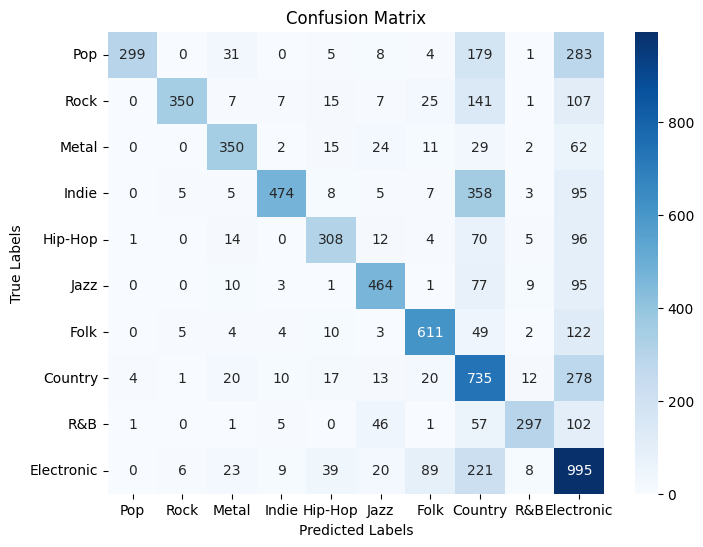

Classification Report:
              precision    recall  f1-score   support

         Pop       0.98      0.37      0.54       810
        Rock       0.95      0.53      0.68       660
       Metal       0.75      0.71      0.73       495
       Indie       0.92      0.49      0.64       960
     Hip-Hop       0.74      0.60      0.66       510
        Jazz       0.77      0.70      0.74       660
        Folk       0.79      0.75      0.77       810
     Country       0.38      0.66      0.49      1110
         R&B       0.87      0.58      0.70       510
  Electronic       0.45      0.71      0.55      1410

    accuracy                           0.62      7935
   macro avg       0.76      0.61      0.65      7935
weighted avg       0.72      0.62      0.63      7935



In [66]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

genre_labels = train_df['genre'].unique()  # Or test_df['genre'] if you want the test set

best_model = load_model('part_1_new/best_rnn_model_with_artist.keras')

# Step 1: Run predictions on the test data
predictions = best_model.predict([X_test, X_test_artist])

# Step 2: Convert predicted probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Step 3: Convert the true labels (y_test) from one-hot encoded format to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Step 4: Create confusion matrix
cm = confusion_matrix(y_test_classes, predicted_classes)

# Step 5: Plot the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genre_labels, yticklabels=genre_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 6: Optionally, print classification report for more detailed performance metrics
print("Classification Report:")
print(classification_report(y_test_classes, predicted_classes, target_names=genre_labels))


In [46]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model, Model

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the checkpoint callback dynamically using lambda to include the model name
checkpoint_path = f'part_1_new/best_cnn_model.keras'
checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

# Train CNN Model
history_cnn = cnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, checkpoint])

cnn_model.summary()

# Load the best model saved during training
best_model = load_model(f'part_1_new/best_cnn_model.keras')

# Evaluate the model on the test data (Block 1)
test_loss, test_acc = best_model.evaluate(X_test, y_test)

# Store the results in the list
results.append({
    'model_name': 'best_cnn_model',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'model_history': history_cnn
})


Epoch 1/10
2901/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5157 - loss: 1.3508
Epoch 1: val_loss improved from inf to 1.15328, saving model to part_1_new/best_cnn_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - accuracy: 0.5157 - loss: 1.3507 - val_accuracy: 0.5974 - val_loss: 1.1533
Epoch 2/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6057 - loss: 1.1428
Epoch 2: val_loss improved from 1.15328 to 1.12907, saving model to part_1_new/best_cnn_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 61s 21ms/step - accuracy: 0.6057 - loss: 1.1428 - val_accuracy: 0.6084 - val_loss: 1.1291
Epoch 3/10
2899/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6326 - loss: 1.0689
Epoch 3: val_loss improved from 1.12907 to 1.12584, saving model to part_1_new/best_cnn_model.keras
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - accuracy: 0.6326 - loss: 1.0689 - val_accuracy: 0.6125 - val_loss: 1.1258
Epoch 4/10
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6560 

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 98, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 45, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,237,856 (16.17 MB)

 Trainable params: 1,412,618 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,825,238 (10.78 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2670 - loss: 2.6238


In [47]:
import pickle

# Save the results array to a file
with open('results_v1_part1.pkl', 'wb') as file:
    pickle.dump(results, file)
print("Results array saved to 'results_v1_part1.pkl'.")

Results array saved to 'results_v1_part1.pkl'.


Results array loaded from 'results_v1_part1.pkl'.


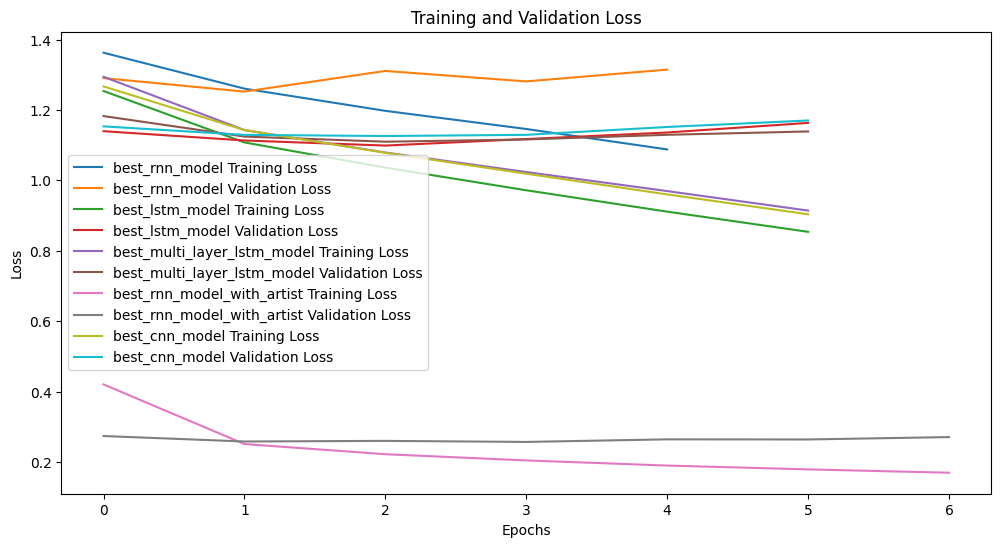

In [63]:
import pickle
import matplotlib.pyplot as plt


# Load the results array from a file
with open('results_v1_part1.pkl', 'rb') as file:
    loaded_results = pickle.load(file)
print("Results array loaded from 'results_v1_part1.pkl'.")

# Plot training and validation accuracy dynamically
plt.figure(figsize=(12, 6))
for result in loaded_results:
    model_name = result['model_name']
    history = result['model_history']
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Results array loaded from 'results_v1_part1.pkl'.
best_rnn_model Test Accuracy: 0.21424070000648499
best_lstm_model Test Accuracy: 0.2690611183643341
best_multi_layer_lstm_model Test Accuracy: 0.2703213691711426
best_rnn_model_with_artist Test Accuracy: 0.6153749227523804
best_cnn_model Test Accuracy: 0.26036545634269714


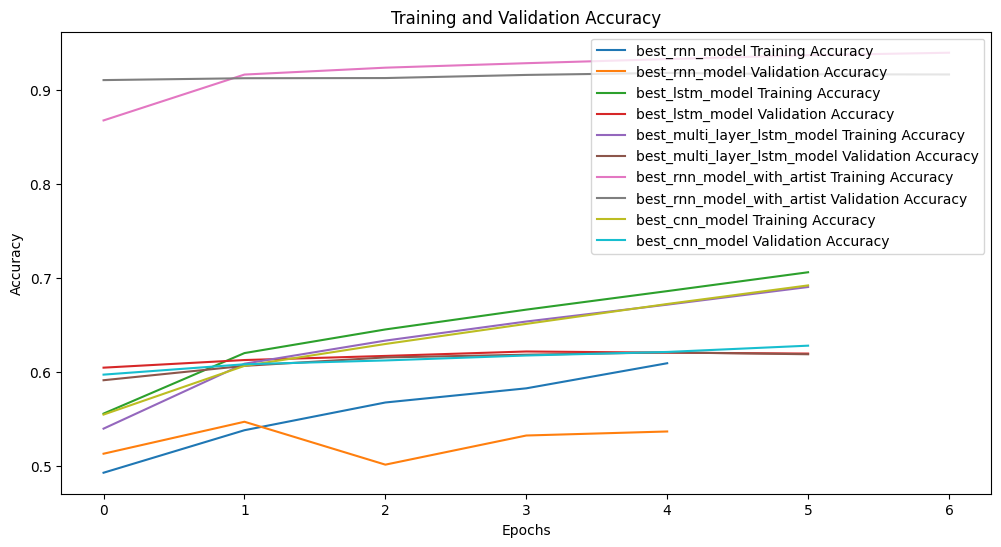

In [67]:
import pickle
import matplotlib.pyplot as plt


# Load the results array from a file
with open('results_v1_part1.pkl', 'rb') as file:
    loaded_results = pickle.load(file)
print("Results array loaded from 'results_v1_part1.pkl'.")


# Print test accuracies dynamically
for result in loaded_results:
    print(f"{result['model_name']} Test Accuracy: {result['test_accuracy']}")

# Plot training and validation accuracy dynamically
plt.figure(figsize=(12, 6))
for result in loaded_results:
    model_name = result['model_name']
    history = result['model_history']
    plt.plot(history.history['accuracy'], label=f'{model_name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Results array loaded from 'results_v1_part1.pkl'.
best_rnn_model Test Accuracy: 0.21424070000648499, Test Loss: 2.890493154525757
best_lstm_model Test Accuracy: 0.2690611183643341, Test Loss: 2.667471170425415
best_multi_layer_lstm_model Test Accuracy: 0.2703213691711426, Test Loss: 2.5926403999328613
best_rnn_model_with_artist Test Accuracy: 0.6153749227523804, Test Loss: 1.2896618843078613
best_cnn_model Test Accuracy: 0.26036545634269714, Test Loss: 2.6401145458221436


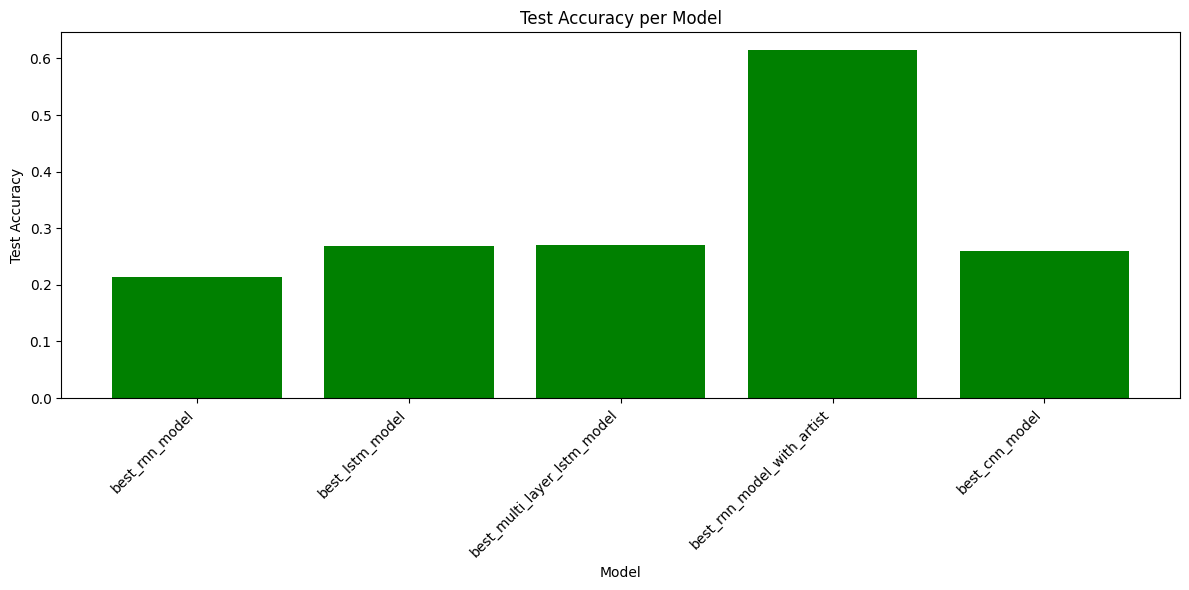

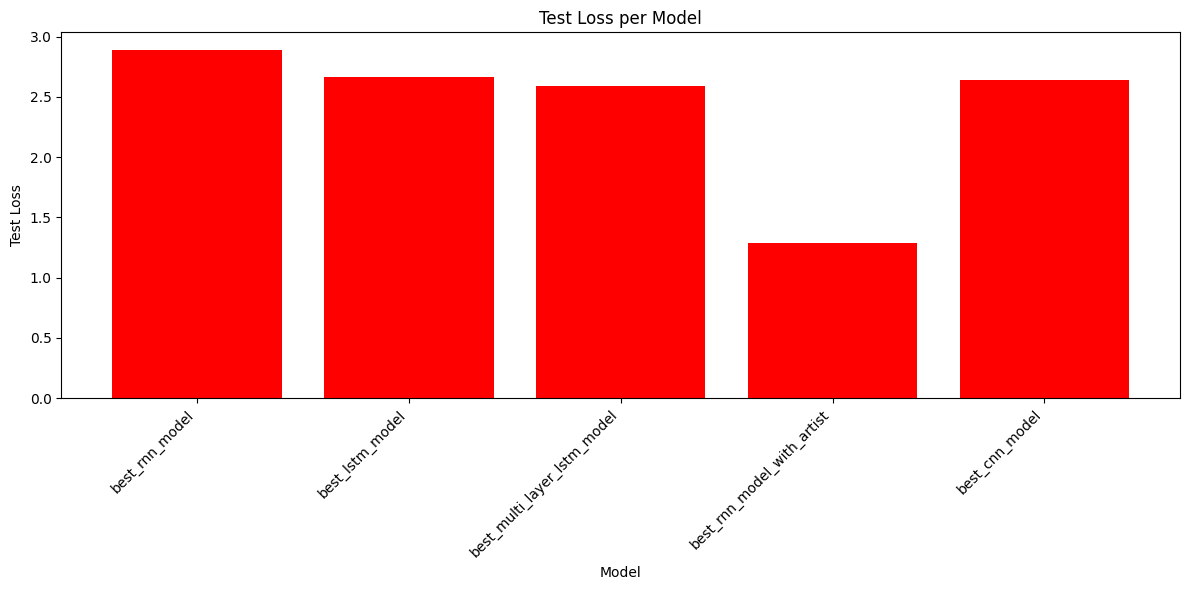

In [52]:
import pickle
import matplotlib.pyplot as plt

# Load the results array from a file
with open('results_v1_part1.pkl', 'rb') as file:
    loaded_results = pickle.load(file)
print("Results array loaded from 'results_v1_part1.pkl'.")

# Print test accuracies dynamically
for result in loaded_results:
    print(f"{result['model_name']} Test Accuracy: {result['test_accuracy']}, Test Loss: {result['test_loss']}")

# Prepare data for bar plots
model_names = [result['model_name'] for result in loaded_results]
test_accuracies = [result['test_accuracy'] for result in loaded_results]
test_losses = [result['test_loss'] for result in loaded_results]

# Plot Test Accuracy Bar Plot
plt.figure(figsize=(12, 6))
plt.bar(model_names, test_accuracies, color='green')
plt.title('Test Accuracy per Model')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate model names for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of x-axis labels
plt.show()

# Plot Test Loss Bar Plot
plt.figure(figsize=(12, 6))
plt.bar(model_names, test_losses, color='red')
plt.title('Test Loss per Model')
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.xticks(rotation=45, ha='right')  # Rotate model names for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of x-axis labels
plt.show()


In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


model_url = "https://github.com/fizz3r/ml/raw/main/part_1_v2/best_rnn_model_with_artist_2.keras"
model_filename = "best_rnn_model_with_artist_2.keras"

model_path = tf.keras.utils.get_file(model_filename, model_url)
best_rnn_model_with_artist_2 = tf.keras.models.load_model(model_path)

predictions = best_rnn_model_with_artist_2.predict([X_test, X_test_artist])
# Convert the predicted probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Convert the true labels (y_test) to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_classes, predicted_classes)

print(f"Prediction Accuracy: {accuracy}")

# Step 4: Evaluate the model on the test data
test_loss, test_acc = best_rnn_model_with_artist_2.evaluate([X_test, X_test_artist], y_test)

# Print the evaluation results (loss and accuracy)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Prediction Accuracy: 0.6153749212350347
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6153 - loss: 1.2602
Test Loss: 1.2896618843078613
Test Accuracy: 0.6153749227523804


In [69]:
import pickle

# Assuming X_test, X_test_artist, and y_test are your test data

# Save X_test to a pickle file
with open('X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)
print("X_test saved to 'X_test.pkl'.")

# Save X_test_artist to a pickle file
with open('X_test_artist.pkl', 'wb') as file:
    pickle.dump(X_test_artist, file)
print("X_test_artist saved to 'X_test_artist.pkl'.")

# Save y_test to a pickle file
with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)
print("y_test saved to 'y_test.pkl'.")

X_test saved to 'X_test.pkl'.
X_test_artist saved to 'X_test_artist.pkl'.
y_test saved to 'y_test.pkl'.
